In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
})

In [2]:
import wandb

api = wandb.Api()
dp_sweep = api.sweep("dpfrommer-projects/diffusion-policy/uf0aq7se")
im_sweep = api.sweep("dpfrommer-projects/image_diffusion/a5yda2f7")

In [3]:
def fetch_data(sweep):
    datas = []
    for run in sweep.runs:
        if run.state == "finished":
            seed = run.config["seed"]
            history = run.history(keys=["test/loss", "test/ot_distance"])
            history["seed"] = seed
            datas.append(history)
    return pd.concat(datas)

dp_data = fetch_data(dp_sweep)
im_data = fetch_data(im_sweep)

In [4]:
dp_means = dp_data.groupby("_step").mean().reset_index()
dp_std = dp_data.groupby("_step").std().reset_index()
im_means = im_data.groupby("_step").mean().reset_index()
im_std = im_data.groupby("_step").std().reset_index()

5
2


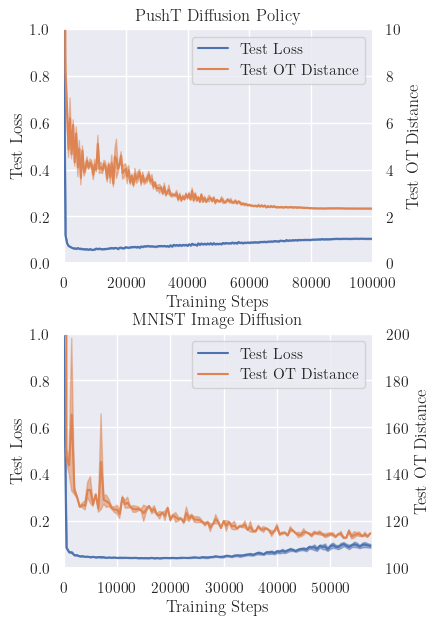

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7))

def plot(ax, df):
    N = len(df["seed"].unique())
    print(N)
    means = df.groupby("_step").mean().reset_index()
    steps = means["_step"]
    std = df.groupby("_step").std().reset_index()
    mean_loss, mean_ot = means["test/loss"], means["test/ot_distance"]
    std_loss, std_ot = std["test/loss"] / np.sqrt(N), std["test/ot_distance"] / np.sqrt(N)

    ax_twin = ax.twinx()
    ax_twin.grid(False)
    h1, = ax.plot(steps, mean_loss, label="Test Loss", color=colors[0])
    ax.fill_between(steps, mean_loss - std_loss, mean_loss + std_loss, alpha=0.5, color=colors[0])

    h2, = ax_twin.plot(steps, mean_ot, color=colors[1], label="Test OT Distance")
    ax_twin.fill_between(steps, mean_ot + std_ot, mean_ot - std_ot, alpha=0.5, color=colors[1])
    ax_twin.legend(handles=[h1,h2], loc="upper right")

    ax.tick_params(axis="y", left=False, right=False)
    ax_twin.tick_params(axis="y", left=False, right=False)
    return ax_twin


ax1.set_title("PushT Diffusion Policy")
ax1_twin = plot(ax1, dp_data)

ax1.set_xlim(-300, 100_000)
ax2.set_xlim(-150, 58_000)

ax1.set_ylim(0, 1)
ax1.set_yticks(np.linspace(0, 1, 6))
ax1_twin.set_ylim(0, 10)
ax1_twin.set_yticks(np.linspace(0, 10, 6))

ax2.set_title("MNIST Image Diffusion")
ax2_twin = plot(ax2, im_data)

ax1.set_xlim(-300, 100_000)

ax2.set_ylim(0,1)
ax2.set_yticks(np.linspace(0, 1, 6))
ax2_twin.set_ylim(100, 200)
ax2_twin.set_yticks(np.linspace(100, 200, 6))
# ax2_twin.set_ylim(0, 0.2)

ax1.set_ylabel("Test Loss")
ax1_twin.set_ylabel("Test OT Distance")
ax2.set_ylabel("Test Loss")
ax2_twin.set_ylabel("Test OT Distance")

ax1.set_xlabel("Training Steps")
ax2.set_xlabel("Training Steps")

fig.subplots_adjust(hspace=0.3)
fig.savefig("training_curves.pdf", bbox_inches="tight")
fig.show()